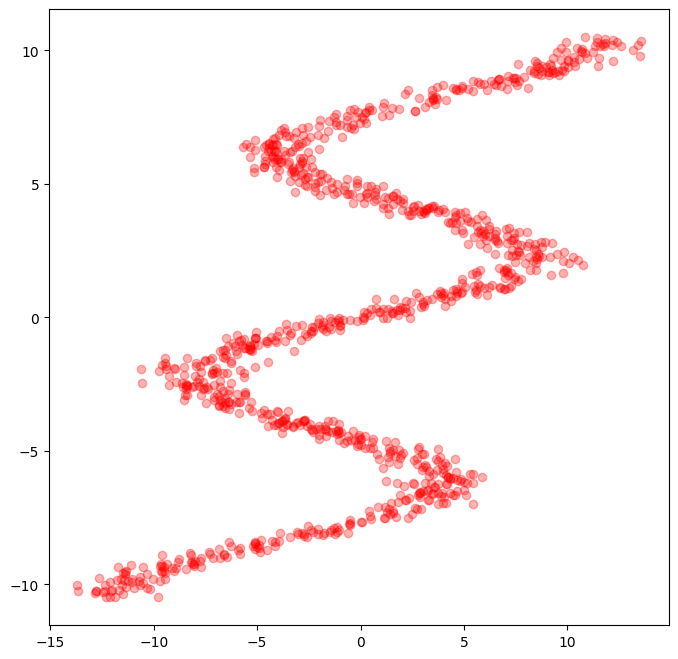

In [1]:
import numpy as np
import matplotlib.pyplot as plt

NSAMPLE = 1000

# 정의역 in english is "domain"
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
tmp_data = x_data
r_data = np.float32(np.random.normal(size=(NSAMPLE, 1)))
# 치역 in english is "range"

# we will swap the domain and range to show the power of the neural network
y_data = np.float32(np.sin(0.75 * x_data) * 7.0 + x_data * 0.5 + r_data * 1.0)
x_data = y_data
y_data = tmp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.show()



For a given value x, the liklihood of x to happen in a distribution in $N(\mu, \sigma)$ is

$$
p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$



In [2]:
import sys
sys.path.append('..')
import dezero
import dezero.functions as F
import dezero.layers as L
import dezero.models as M
import math



NHIDDEN = 24
STDEV = 0.5
KMIX = 24
NOUT = KMIX * 3 # pi, mu, stdev



class MDN(dezero.Model):
    def __init__(self, n_input, n_hidden, n_gaussians):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.z_h = M.Sequential(L.Linear(n_hidden), F.tanh)
        self.z_pi = L.Linear(n_hidden, n_gaussians)
        self.z_sigma = L.Linear(n_hidden, n_gaussians)
        self.z_mu = L.Linear(n_hidden, n_gaussians)
        

    def forward(self, inputs):
        if inputs.shape[1] != self.n_input:
            raise ValueError("inputs must have " + str(self.n_input) + " dimensions")
        z_h = self.z_h(inputs)
        pi = F.softmax(self.z_pi(z_h))
        sigma = F.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, mu, sigma
    
    # Sinvle variable gaussian
    def gaussian_1d_pdf(self, y, mu, sigma):
        oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
        # the result means the probability of y in the normal distribution
        # we check the probability of y in the normal distribution
        # if the probability is high, the result is close to 1
        # There is no
        result = F.sub(y, mu)  # y - mu
        result = F.div(result, sigma) # 이것은 sigma matrix를 역수로 바꾸고 곱한 것 # (y - mu) / sigma
        result = F.pow(result, 2) # 제곱 # (y - mu)^2 / sigma^2
        result = F.mul(result, -0.5) # -0.5 * (y - mu)^2 / sigma^2
        result = F.exp(result) # e^(-0.5 * (y - mu)^2 / sigma^2)
        # sigmd의 역수
        # https://kangbk0120.github.io/articles/2018-05/MDN
        # make a oneDivSqrtTwoPI tensor
        tmp_tensor = np.ones(sigma.shape) * oneDivSqrtTwoPI # 1 / sqrt(2 * pi)
        
        result = F.mul(result, F.div(tmp_tensor, sigma)) # (1 / sqrt(2 * pi)) * e^(-0.5 * (y - mu)^2 / sigma^2) / sigma
        return result

    def get_1d_lossfunc(self, y, pi, mu, sigma):
        result = self.gaussian_1d_pdf(y, mu, sigma) # the probability of y in the normal distribution
        result = F.mul(result, pi) # pi is the weight of the normal distribution
        result = F.sum(result, axis=1)
        result = -F.log(result) # log likelihood
        # we minus the log likelihood since we want to maximize the log likelihood
        # The real goal is to maximize the log likelihood of the real data
        return F.mean(result)
    

In [3]:
# train model

model = MDN(n_input=1, n_hidden=NHIDDEN, n_gaussians=KMIX)

optimizer = dezero.optimizers.Adam().setup(model)


for epoch in range(1000):
    y = model(x_data)
    loss = model.get_1d_lossfunc(y_data, *y)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    print('epoch:', epoch, 'loss:', loss.data)
    

epoch: 0 loss: 4.669187756446071
epoch: 1 loss: 4.632144607947528
epoch: 2 loss: 4.5960470655805565
epoch: 3 loss: 4.560849499670837
epoch: 4 loss: 4.526493717037299
epoch: 5 loss: 4.492910544621447
epoch: 6 loss: 4.4600223923983675
epoch: 7 loss: 4.427746211996418
epoch: 8 loss: 4.395997117971791
epoch: 9 loss: 4.364692545037037
epoch: 10 loss: 4.333755906343964
epoch: 11 loss: 4.303119171017554
epoch: 12 loss: 4.272724836371502
epoch: 13 loss: 4.242527545752466
epoch: 14 loss: 4.212495748035272
epoch: 15 loss: 4.182613152854799
epoch: 16 loss: 4.1528796716254925
epoch: 17 loss: 4.123311055885459
epoch: 18 loss: 4.093936905042346
epoch: 19 loss: 4.064796841257406
epoch: 20 loss: 4.035936265748003
epoch: 21 loss: 4.007402347269789
epoch: 22 loss: 3.9792426026953067
epoch: 23 loss: 3.9515057542132728
epoch: 24 loss: 3.9242443669386855
epoch: 25 loss: 3.897517399895273
epoch: 26 loss: 3.8713901843366263
epoch: 27 loss: 3.8459311975608843
epoch: 28 loss: 3.8212052083634416
epoch: 29 loss:

In [4]:
# test model

x_test = np.float32(np.arange(-15, 15, 0.1))
print(x_test.size)
NTEST = x_test.size
print(NTEST)
x_test = x_test.reshape(NTEST, 1)

# this function is used to sample the ensemble
# the pi is the probability of each ensemble
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    print('error with sampling ensemble')
    return -1

# this function is used to sample the ensemble
# an ensemble is a set of mu, sigma, pi
def generate_ensemble(out_pi, out_mu, out_sigma, M=15):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(M):
        for i in range(NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std 
            # result is a 2D matrix, the first dimension is the number of test data
    return result


300
300


(300, 24) (300, 24) (300, 24)
(300, 1)
(300, 15)


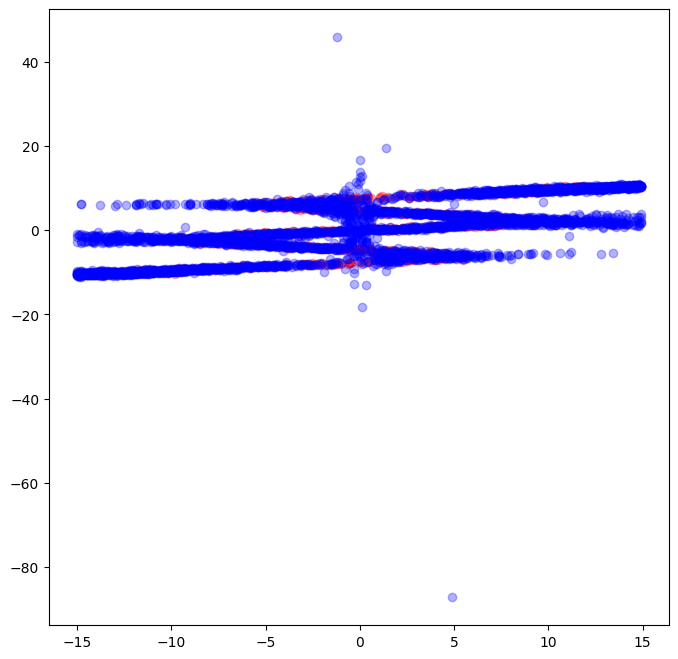

In [5]:

y = model(x_test)
pi, mu, sigma = y
print(pi.shape, mu.shape, sigma.shape)


print(x_test.shape)
y_test = generate_ensemble(pi.data, mu.data, sigma.data)

print(y_test.shape)

plt.figure(figsize=(8, 8))
plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.plot(x_test, y_test, 'bo', alpha=0.3)
plt.show()


In [6]:
# check if sum of pi is 1
print(pi.data.shape)

for i in range(10):
    print(np.sum(pi.data[i]))

(300, 24)
1.0000001
0.9999999
1.0
1.0
1.0
0.9999999
1.0
0.99999994
1.0
1.0


(1000, 2)


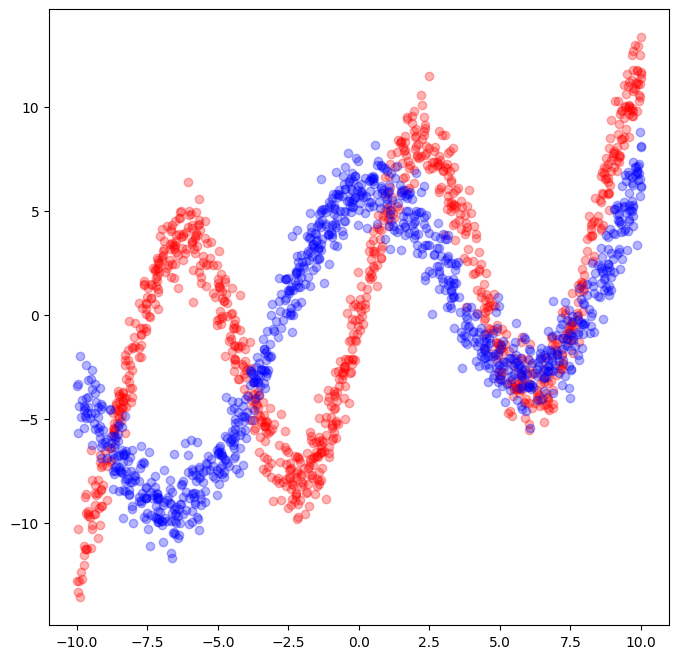

In [7]:

# now let's try with bivariate gaussian

# create a new function
# create a heart graph
NSAMPLE = 1000
z_data = np.float32(np.random.uniform(-10, 10, (1, NSAMPLE))).T
x1 = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + np.random.normal(size=(NSAMPLE, 1)) * 1.0
x2 = np.cos(0.5 * z_data) * 6.0 + z_data * 0.5 + np.random.normal(size=(NSAMPLE, 1)) * 1.0

x1_data = z_data.copy() # this will be used for testing the bivariate gaussian
x2_data = z_data.copy() # this will be used for testing the bivariate gaussian

x1_x2_data = np.c_[x1_data, x2_data]

x1_x2_answer = np.c_[x1, x2]

print(x1_x2_data.shape)

# plot both x1 and x2 with z as domain
plt.figure(figsize=(8, 8))
plt.plot(z_data, x1, 'ro', alpha=0.3)
plt.plot(z_data, x2, 'bo', alpha=0.3)
plt.show()


Reference: https://mathworld.wolfram.com/BivariateNormalDistribution.html

For a given value x1 and x2, the likelihood of x1 and x2 to happen in a bivariate density function where $( \mu_1, \mu_2 )$ are the means, $( \sigma_1, \sigma_2 )$ are the standard deviations, and $( \rho )$ is the correlation coefficient of $( x_1 )$ and $( x_2 )$, respectively, is below

$$
P(x_1, x_2) = \frac{1}{2 \pi \sigma_1 \sigma_2 \sqrt{1-\rho^2}} \exp\left(-\frac{z}{2(1-\rho^2)}\right)
$$

where $z$ is below

$$
z \equiv \frac{(x_1 - \mu_1)^2}{\sigma_1^2} - \frac{2\rho(x_1 - \mu_1)(x_2 - \mu_2)}{\sigma_1 \sigma_2} + \frac{(x_2 - \mu_2)^2}{\sigma_2^2}
$$

and $\rho$ is below

$$
\rho \equiv \text{cor}(x_1, x_2) = \frac{V_{12}}{\sigma_1 \sigma_2},
$$

By the way $\rho$ is the pearson correlation 

The $V_{12}$ is the covariance

$$
V_{12} = \text{E}[(x_1 - \mu_1)(x_2 - \mu_2)],
$$


In [8]:

import sys
sys.path.append('..')
import dezero
import dezero.functions as F
import dezero.layers as L
import dezero.models as M
from dezero import cuda
import math



NHIDDEN = 24
STDEV = 0.5
KMIX = 24
NOUT = KMIX * 6 + 1 # pi, mu1, mu2, sigma1, sigma2, rho, eos


# https://github.com/cpmpercussion/keras-mdn-layer

class BiMDN(dezero.Model):
    def __init__(self, n_input, n_hidden, n_gaussians):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        # z_h should get 2 inputs since it is a bivariate gaussian
        self.z_h = M.Sequential(L.Linear(n_hidden), F.tanh)
        self.z_pi = L.Linear(n_hidden, n_gaussians) # Mixing coefficient
        self.z_sigma1 = L.Linear(n_hidden, n_gaussians) # Standard deviation
        self.z_sigma2 = L.Linear(n_hidden, n_gaussians) # Standard deviation
        self.z_mu1 = L.Linear(n_hidden, n_gaussians) # Mean
        self.z_mu2 = L.Linear(n_hidden, n_gaussians) # Mean
        self.z_rho = L.Linear(n_hidden, n_gaussians) # Correlation
        

    def forward(self, inputs):
        # inputs should have a shape of (batch_size, n_input)
        # for this BiMDN, n_input should be 2
        if inputs.shape[1] != self.n_input:
            raise ValueError("inputs must have " + str(self.n_input) + " dimensions")
        z_h = self.z_h(inputs)
        pi = F.softmax(self.z_pi(z_h))
        sigma1 = F.exp(self.z_sigma1(z_h))
        sigma2 = F.exp(self.z_sigma2(z_h))
        mu1 = self.z_mu1(z_h)
        mu2 = self.z_mu2(z_h)
        rho = F.tanh(self.z_rho(z_h)) # this is the correlation coefficient
        # since rho should be from -1 to 1 we use tanh
        # the correlation coefficient should between -1 and 1
        return pi, mu1, mu2, sigma1, sigma2, rho
    

    def gaussian_2d_pdf(self, y1, y2, mu1, mu2, sigma1, sigma2, rho):
        # the result means the probability of y in the normal distribution
        # we check the probability of y in the normal distribution
        # if the probability is high, the result is close to 1
        norm1 = F.sub(y1, mu1)
        norm2 = F.sub(y2, mu2)
        xp = cuda.get_array_module(norm1)

        
        s1s2 = F.mul(sigma1, sigma2)
        
        # This is from: https://github.com/hardmaru/write-rnn-tensorflow/blob/master/model.py
        # z = tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2))
        #     - 2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
         
        # below is the deconstruction of the above linez
        z_first_term = F.pow(F.div(norm1, sigma1), 2)
        z_second_term = F.pow(F.div(norm2, sigma2), 2)
        z_last_term_inner = F.mul(rho, F.mul(norm1, norm2))
        z_last_term_middle = F.div(z_last_term_inner, s1s2)
        tmp_z = np.ones(z_last_term_middle.shape) * -2
        z_last_term = F.mul(tmp_z, z_last_term_middle)
        z = F.add(F.add(z_first_term, z_second_term), z_last_term)
        negRho = F.sub(np.ones(rho.shape), F.pow(rho, 2))

        
        result = F.exp(F.div(-z, 2 * negRho))
        deno_first_term = np.ones(sigma1.shape) * 2 * math.pi
        denom_second_term = F.mul(s1s2, F.pow(negRho, 0.5))
        denom = F.mul(deno_first_term, denom_second_term)
        result = F.div(result, denom)
        
        return result
        
    def get_2d_lossfunc(self, z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, x1_data, x2_data, z_eos=None, eos_data = None):
        result0 = self.gaussian_2d_pdf(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr)
        
        elipson = 1e-20
        # check if result0 has inf or nan
        result1 = F.mul(result0, z_pi)
        result1 = F.sum(result1, axis=1, keepdims=True)
        # elipson_matrix = np.ones(result1.shape) * elipson
        xp = cuda.get_array_module(result1)
        result1 = -F.log(result1)
        
        if eos_data is None or z_eos is None:
            return F.mean(result1)
        
        result2 = F.mul(z_eos, eos_data) + F.mul(1 - z_eos, 1 - eos_data)
        result2 = -F.log(result2)
        
        # sum all 
        return F.mean(result1, result2)

    # 2d
    # def get_mixture_coef(output):
    #     xp = cuda.get_array_module(x)
    #     z = output
    #     z_eos = z[:, 0:1]
        
    #     # what split does here is to split the z into 6 parts
    #     # z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr
    #     z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = xp.split(z[:, 1:], 6, axis=1)
        
    #     z_eos = F.sigmoid(z_eos)
        
    #     # softmax all the pi's
    #     max_pi = F.max(z_pi, axis=1, keepdims=True)
    #     z_pi = F.sub(z_pi, max_pi)
    #     z_pi = F.exp(z_pi)
        
    #     tmp_tensor = np.ones(z_pi.shape) 
        
    #     tmp_tensor = F.sum(z_pi, axis=1, keepdims=True)

    #     normalize_pi = F.div(tmp_tensor, z_pi) # this is the reciprocal of the sum of pi
        
    #     z_pi = F.mul(normalize_pi, z_pi)
        
    #     # exponentiate the sigmas and also make corr between -1 and 1
    #     z_sigma1 = F.exp(z_sigma1)
    #     z_sigma2 = F.exp(z_sigma2)
    #     z_corr = F.tanh(z_corr)
        
    #     return [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos]
        
        
        
    

In [9]:
model = BiMDN(n_input=2, n_hidden=NHIDDEN, n_gaussians=KMIX)

In [10]:


optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(20000):
    y = model(x1_x2_data)
    # model returns pi, mu1, mu2, sigma1, sigma2, rho
    loss = model.get_2d_lossfunc(*y, x1, x2)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    print('epoch:', epoch, 'loss:', loss.data)
    # check if loss.data has inf or nan
    if loss.data == float('inf') or loss.data != loss.data:
        break

epoch: 0 loss: 13.043854724243946
epoch: 1 loss: 12.608649118244848
epoch: 2 loss: 12.18398031865683
epoch: 3 loss: 11.779709606302443
epoch: 4 loss: 11.400935438427917
epoch: 5 loss: 11.047724882745635
epoch: 6 loss: 10.718857301086638
epoch: 7 loss: 10.413015429700996
epoch: 8 loss: 10.128910312044699
epoch: 9 loss: 9.865407863969436
epoch: 10 loss: 9.621425481278767
epoch: 11 loss: 9.395845273765076
epoch: 12 loss: 9.187576817089601
epoch: 13 loss: 8.995572394320005
epoch: 14 loss: 8.81869762084521
epoch: 15 loss: 8.655759593911771
epoch: 16 loss: 8.505651527873788
epoch: 17 loss: 8.367351123557594
epoch: 18 loss: 8.239867488880444
epoch: 19 loss: 8.122213308321209
epoch: 20 loss: 8.013421745607834
epoch: 21 loss: 7.912567978853422
epoch: 22 loss: 7.818818971890169
epoch: 23 loss: 7.731477327395443
epoch: 24 loss: 7.64997745610501
epoch: 25 loss: 7.573840024871333
epoch: 26 loss: 7.502613583631277
epoch: 27 loss: 7.4358806495170615
epoch: 28 loss: 7.373315751153445
epoch: 29 loss: 7

In [11]:
def generate_ensemble_2d(out_pi, out_mu1, out_mu2, out_sigma1, out_sigma2, out_corr, out_eos = None, M=15):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M, 3) # initially random [0, 1]
    rn = np.random.randn(NTEST, M, 2) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(M):
        for i in range(NTEST):
            idx = get_pi_idx(result[i, j, 0], out_pi[i])
            mu = [out_mu1[i, idx], out_mu2[i, idx]]
            std = [out_sigma1[i, idx], out_sigma2[i, idx]]
            rho = out_corr[i, idx]
            eos = 0
            if out_eos is not None:
                eos = out_eos[i]
            
            # we sample from the 2D gaussian
            result[i, j, 0:2] = mu + rn[i, j]*std
            result[i, j, 2] = eos
    return result

(300, 2)
(300, 24) (300, 24) (300, 24) (300, 24) (300, 24) (300, 24)
(300, 15) (300, 15)
(300, 1)


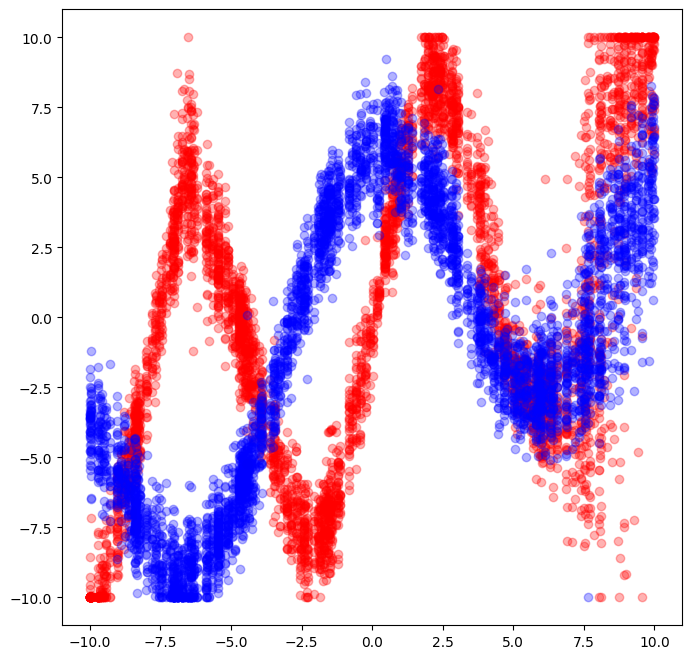

In [12]:

z_data = np.float32(np.random.uniform(-10, 10, (1, NTEST))).T
x1_test = z_data.copy()
x2_test = z_data.copy()


x1_x2_test = np.c_[x1_test, x2_test]
print(x1_x2_test.shape)

y = model(x1_x2_test)
pi, mu1, mu2, sigma1, sigma2, rho = y
print(pi.shape, mu1.shape, mu2.shape, sigma1.shape, sigma2.shape, rho.shape)

y_test = generate_ensemble_2d(pi.data ,mu1.data, mu2.data, sigma1.data, sigma2.data, rho.data)

# get y1_test
y1_test = y_test[:, :, 0]
y2_test = y_test[:, :, 1]

print(y1_test.shape, y2_test.shape)

# clip data that is outside the range
y1_test = np.clip(y1_test, -10, 10)
y2_test = np.clip(y2_test, -10, 10)


# plot both x1 and x2 with z as domain
plt.figure(figsize=(8, 8))
print(x1_test.shape)
plt.plot(z_data, y1_test, 'ro', alpha=0.3)
plt.plot(z_data, y2_test, 'bo', alpha=0.3)
plt.show()

